[EdB]:https://www.christies.com/features/A-collaboration-between-two-artists-one-human-one-a-machine-9332-1.aspx

# Artwork

Here is an attempt at "digital artwork", albeit in a much rougher fashion than the GAN-created [Edmond de Belamy][EdB].

The code of this project replicates an original image by taking random cutouts of it and filling them with colors approximating the original.

**How it works**  
The code replicates an image by:
1. Initializing the replica as a black image of the same shape as the original.
2. Randomly selecting a cutout (rectangular or circular) inside the original image.
3. Calculating the mean RGB color in the cutout.
4. Filling the cutout with the color obtained in the previous step.
5. Adding the cutout to the replica (at the same position than on the original image). If the replica gets closer to the original image (L2 loss), keep the cutout on. Otherwise, discard it.
6. Repeating steps 2-5 n times.

If ran long enough, the code has the capacity to render an exact copy of the original image. This is because all types of cutouts can be created at anytime: all improvements are kept and 1x1 pixels cutouts replicate the original image perfectly. As the number of iterations grows, the replica gets closer and closer to the original.

**Some details**  
- There are at maximum 4 objects in memory at any time: the original picture, the cutout, a replica, a second replica on which we apply the cutout (and that either replaces the replica or is discarded). All sizes of objects in memory are bounded and not growing.
- Since we work on a single object and since operations are not independent, we cannot multithread the work.
- Time complexity is linearly dependent on the number of iterations. On my machine, for rectangular cutouts: 190 it/s for a 779x976 grayscale image, 80 it/s for a 853x575 color image, and 30 it/s for a 1280x809 color image. Note that after a high number of iterations most random cutouts are discarded as non-improvements, thus pruning some matrices operations and increasing the it/s rate.

**Other notes**  
In the first implementation of this work, the cutouts were not filled with the mean-RGB colors but with random colors.  
Since the algorithm judges improvements to the replica on L2 loss, the mean-RGB color is a cutout's best try at being an improvement.  
On grayscale image, the end results were similar. However, random-color was expectedly taking many more iterations.
On color images, random-color was too time-complex to be used on anything other than small images. Even then, no beautiful result came out of it.


This endeavor is inspired by work I came across online a few years back. However, having unsuccessfully tried to find it again, no link can appear here.
The number of iterations is maintained relatively low throughout this notebook to keep execution time low. However, increasing n_iter yields beautiful results.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from tqdm import tqdm
np.random.seed(0)

# Utils

In [2]:
def rgb2gray(rgb):
    """
    Turns a RGB(A) matrix into a grayscale one. Uses a formula drawn from
    https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    Code from https://stackoverflow.com/questions/12201577/
    
    :param rgb: np.array with 3D shape.
    :return: np.array with a 2D shape
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
def loss(pred, true, loss_fct=np.square):
    """
    Sum A_{i,j}^2, for a given matrix A
    :param pred: np.array 
    :param rgb: np.array
    :param loss_fct: callable
    :return: float
    """
    return np.sum(loss_fct(pred - true))

In [4]:
def mean_color(original_image, mask):
    """
    Calculate the mean color on a cutout of an image
    :param original_image: np.array
    :param mask:
    :return: float or (float, float, float), mean RGB color of the cutout
    """
    if len(original_image.shape) == 2:  # Only height and width => Black and White
        return np.mean(original_image[mask])
    else:  # 3D => Color image
        # We here split the (h, w, 3) RGB matrix in 3 (h, w) matrices and calculate 3 averages.
        return [np.mean(x[mask]) for x in np.split(original_image, indices_or_sections=3, axis=2)]

In [5]:
def rect_mask(original_image):
    """
    Draw a rectangular cutout from the original image.
    :param original_image: np.array
    :return: np.array of bool
    """
    # Get the four points defining the rectangle cutout
    i_min, i_max = sorted(np.random.randint(0, original_image.shape[0] + 1, 2))
    j_min, j_max = sorted(np.random.randint(0, original_image.shape[1] + 1, 2))

    mask = np.zeros(original_image.shape[:2], dtype=bool)
    mask[i_min: i_max, j_min:j_max] = True

    return mask

In [6]:
def circle_mask(original_image, max_radius=50):
    """
    Draw a circular cutout from the original image.
    :param original_image: np.array
    :param max_radius: int. Change for different effect
    :return: np.array of bool
    """
    center_i = np.random.randint(1, original_image.shape[0])
    center_j = np.random.randint(1, original_image.shape[1])
    radius = np.random.randint(max_radius)

    y, x = np.ogrid[-center_i:original_image.shape[0] - center_i, -center_j:original_image.shape[1] - center_j]
    mask = x * x + y * y <= radius * radius

    return mask

In [7]:
def upgrade_img(original_image, pred_image, current_loss, mask_shape='rect', max_radius=50):
    """
    Return the modified image if better than the first prediction.
    :param original_image: np.array. image we are trying to replicate
    :param pred_image: np.array. replica we are trying to upgrade.
    :param current_loss: float. Is equal to loss(pred_image, original_image), passed down throughout iter
                         to avoid calculating it multiple times.
    :param mask_shape: str in ['rect', 'circle', 'random']. Shape of the cutouts
    :param max_radius: int. maximum radius of circular masks
    :return: np.array Either pred_image if we did not find an improvement or an once-improved version of it.
    """
    modified_img = pred_image.copy()

    if mask_shape == 'rect':
        mask = rect_mask(original_image)
    elif mask_shape == 'circle':
        mask = circle_mask(original_image, max_radius)
    elif mask_shape == 'random':
        mask = np.random.choice([rect_mask, circle_mask])(original_image)

    color = mean_color(original_image, mask)

    modified_img[mask] = color

    new_loss = loss(modified_img, original_image)

    if new_loss < current_loss:
        # If the loss has decreased, we keep the cutout.
        return modified_img, new_loss
    return pred_image, current_loss

In [8]:
def replicate_img(original_image, n_iter=10000, mask_shape='rect'):
    """
    Create a replica of original_image

    :param original_image: np.array to replicate
    :param n_iter: int
    :param mask_shape: str in ['rect', 'circle', 'random']. Shape of the cutouts
    :return:
    """
    created_img = np.zeros(original_image.shape)  # Start with a black image
    current_loss = loss(created_img, original_image)

    for _ in tqdm(range(n_iter)):
        created_img, current_loss = upgrade_img(original_image, created_img, current_loss, mask_shape)

    return created_img

# First example
## Original image

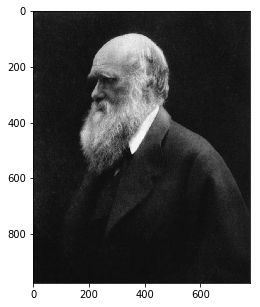

In [9]:
image = img.imread('data/darwin.png')  # Photo of darwin
gray = rgb2gray(image)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(gray, cmap=plt.get_cmap('gray'));

## Rectangular cutouts

In [10]:
replica_r100 = replicate_img(gray, 100, mask_shape='rect')
replica_r1000 = replicate_img(gray, 1000, mask_shape='rect')
replica_r10000 = replicate_img(gray, 1000, mask_shape='rect')
replica_r50000 = replicate_img(gray, 5000, mask_shape='rect')

 73%|███████▎  | 726/1000 [00:04<00:01, 164.89it/s]/home/edgar/Envs/jupyter/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/edgar/Envs/jupyter/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 5000/5000 [00:24<00:00, 208.16it/s]


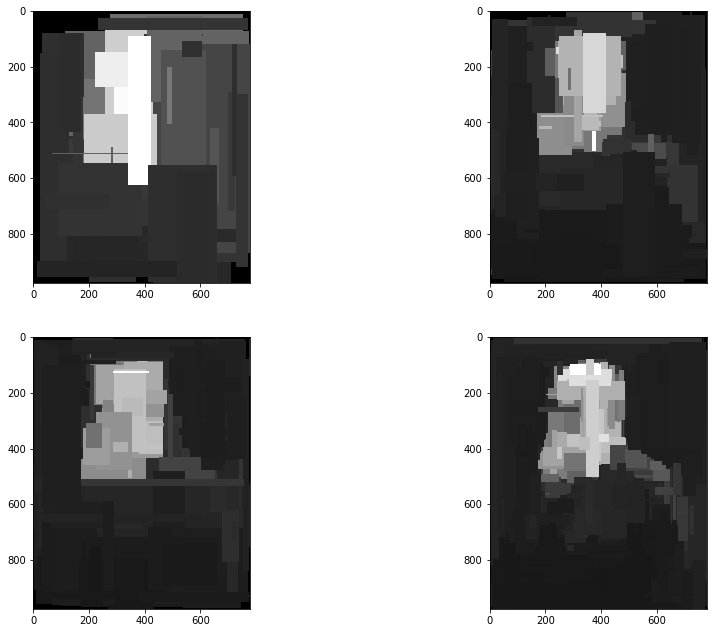

In [11]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,11))
ax1.imshow(replica_r100, cmap=plt.get_cmap('gray'))
ax2.imshow(replica_r1000, cmap=plt.get_cmap('gray'))
ax3.imshow(replica_r10000, cmap=plt.get_cmap('gray'))
ax4.imshow(replica_r50000, cmap=plt.get_cmap('gray'));

## Circular cutouts

In [12]:
replica_c100 = replicate_img(gray, 100, mask_shape='circle')
replica_c1000 = replicate_img(gray, 1000, mask_shape='circle')
replica_c10000 = replicate_img(gray, 1000, mask_shape='circle')
replica_c50000 = replicate_img(gray, 5000, mask_shape='circle')

100%|██████████| 5000/5000 [00:33<00:00, 150.61it/s]


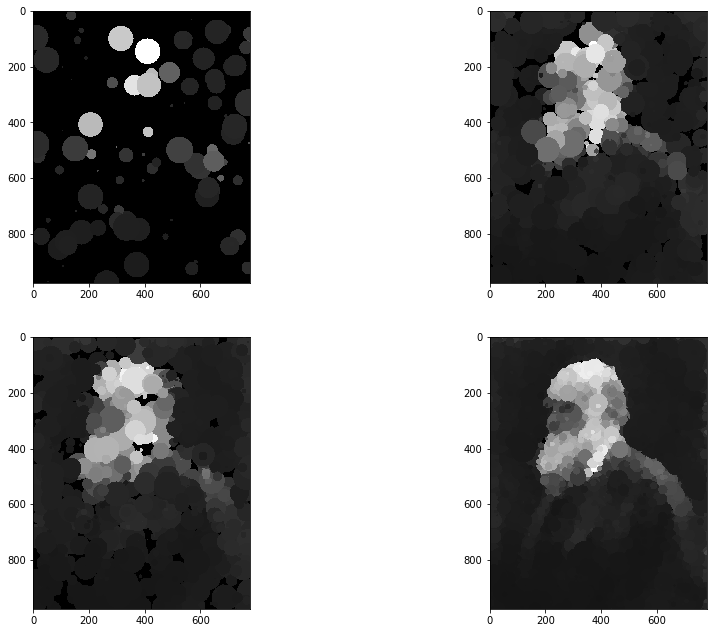

In [13]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,11))
ax1.imshow(replica_c100, cmap=plt.get_cmap('gray'))
ax2.imshow(replica_c1000, cmap=plt.get_cmap('gray'))
ax3.imshow(replica_c10000, cmap=plt.get_cmap('gray'))
ax4.imshow(replica_c50000, cmap=plt.get_cmap('gray'));

## Random cutouts

In [14]:
replica_random = replicate_img(gray, 1000, mask_shape='random')

100%|██████████| 1000/1000 [00:06<00:00, 159.16it/s]


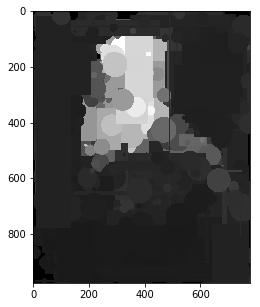

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(replica_random, cmap=plt.get_cmap('gray'));

# Second Example - with Colors

Works just like B&W.

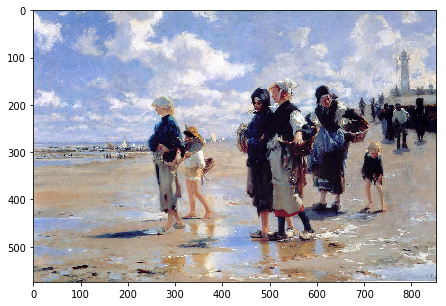

In [16]:
image = img.imread('data/cancale.png')  # Fishing for Oysters at Cancale, by John Sargent
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(image);

In [17]:
replica_color_rect = replicate_img(image, 1000, mask_shape='rect')
replica_color_circ = replicate_img(image, 1000, mask_shape='circle')
replica_color_rand = replicate_img(image, 1000, mask_shape='random')

 46%|████▌     | 456/1000 [00:06<00:07, 72.73it/s]/home/edgar/Envs/jupyter/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:14<00:00, 69.50it/s]


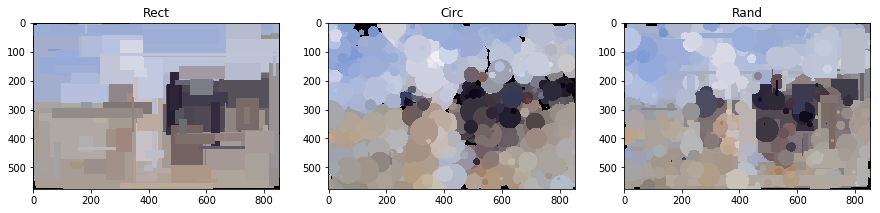

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,9))
ax1.imshow(replica_color_rect)
ax1.set_title('Rect')
ax2.imshow(replica_color_circ)
ax2.set_title('Circ')
ax3.imshow(replica_color_rand)
ax3.set_title('Rand');